<a href="https://colab.research.google.com/github/zohaibkhanzohaibi/NIS-CCP/blob/main/known_plaintext_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting KPA experiment with 160 total trials...

--- Config: Length=100, Key_Len=4 (10 trials) ---
  Trial 1/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 2/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 3/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 4/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 5/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 6/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 7/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 8/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 9/10 complete: Found=True (Candidates=8, Time=0.00s)
  Trial 10/10 complete: Found=True (Candidates=8, Time=0.00s)

--- Config: Length=100, Key_Len=7 (10 trials) ---
  Trial 1/10 complete: Found=True (Candidates=2, Time=0.00s)
  Trial 2/10 complete: Found=True (Candidates=2, Time=0.00s)
  Trial 3/10 complete: Found=True (Candidates=2, Time=0.00s)
  Trial 4/10 complete: Found=True (Candidates=2, Time

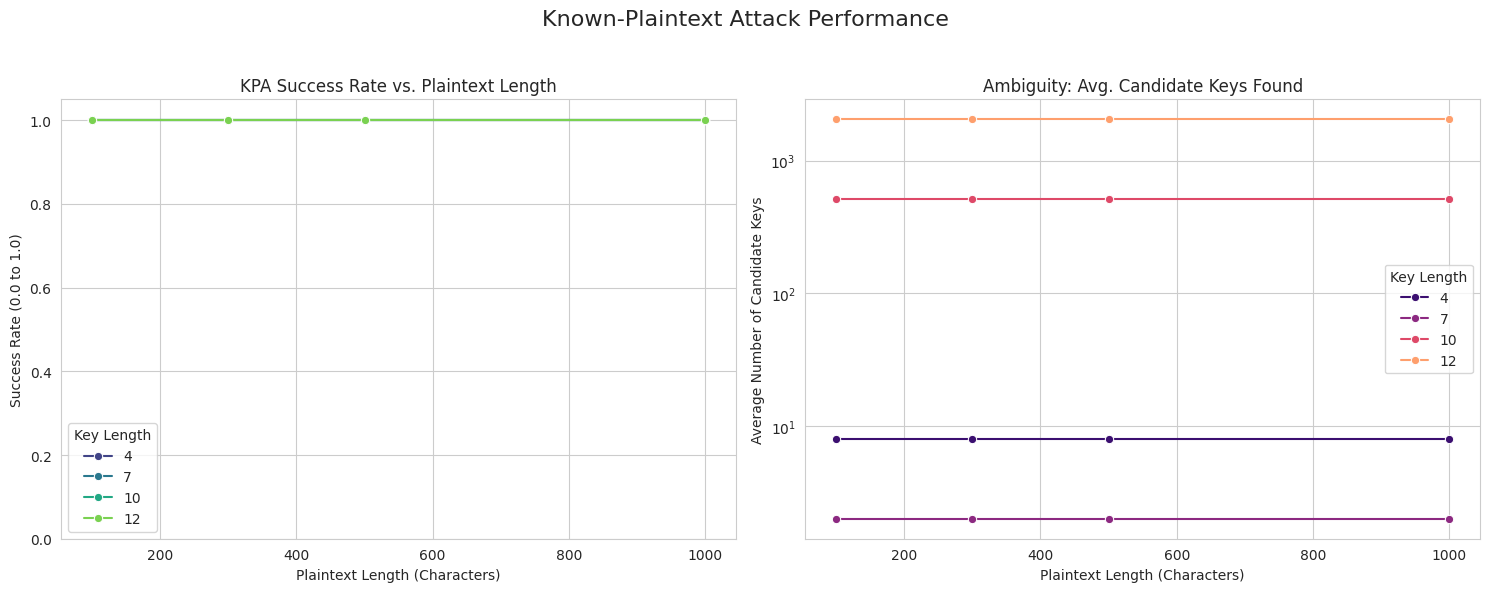

In [ ]:
import random
import time
import math
import string
import statistics
from collections import Counter, defaultdict
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: ALL UTILITY FUNCTIONS (ALPH, A2I, I2A, normalize, caesar_shift_text,
# vigenere_decrypt, composite_decrypt, egcd, inv_mod, solve_congruence_for_k_t,
# and recover_keys_from_known_plaintext) must be included before this section.
# I will include them here for completeness in the Colab run block.

# --------------------------------------------------------------------------------------
# 1. SETUP AND UTILITY FUNCTIONS (Complete block from your prompt)
# --------------------------------------------------------------------------------------

ALPH = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
A2I = {c: i for i, c in enumerate(ALPH)}
I2A = {i: c for i, c in enumerate(ALPH)}

def normalize(s):
    return "".join(ch for ch in s.upper() if ch.isalpha())

def caesar_shift_text(text, shift):
    return "".join(I2A[(A2I[ch] + shift) % 26] for ch in text)

def vigenere_encrypt(text, key): # Added encryptor for generation
    out = []
    for i, ch in enumerate(text):
        k = key[i % len(key)]
        out.append(I2A[(A2I[ch] + k) % 26])
    return "".join(out)

def composite_encrypt(plaintext, key_letters):
    text = normalize(plaintext)
    key = key_letters
    for kr in key:
        text = caesar_shift_text(text, kr)
        text = vigenere_encrypt(text, key)
    return text

def vigenere_decrypt(text, key):
    out = []
    for i, ch in enumerate(text):
        k = key[i % len(key)]
        out.append(I2A[(A2I[ch] - k) % 26])
    return "".join(out)

def composite_decrypt(ciphertext, key_letters):
    text = normalize(ciphertext)
    key = key_letters
    for kr in reversed(key):
        text = vigenere_decrypt(text, key)
        text = caesar_shift_text(text, -kr)
    return text

def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def inv_mod(a, m):
    g, x, _ = egcd(a % m, m)
    if g != 1:
        return None
    return x % m

def solve_congruence_for_k_t(Keff_minus_St, m):
    rhs = Keff_minus_St % 26
    g = math.gcd(m, 26)
    if rhs % g != 0:
        return []
    m_r = m // g
    mod_r = 26 // g
    rhs_r = (rhs // g) % mod_r
    inv = inv_mod(m_r, mod_r)
    sols = []
    if inv is None:
        for cand in range(26):
            if (m * cand - Keff_minus_St) % 26 == 0:
                sols.append(cand % 26)
    else:
        k0 = (rhs_r * inv) % mod_r
        for t in range(g):
            sols.append((k0 + t * mod_r) % 26)
    return sorted(set(sols))

def recover_keys_from_known_plaintext(known_plaintext, known_ciphertext, m):
    P = normalize(known_plaintext)
    C = normalize(known_ciphertext)
    if len(P) != len(C):
        raise ValueError("Known plaintext and ciphertext must align and have same letter count.")

    residues = defaultdict(list)
    for j, (pc, cc) in enumerate(zip(P, C)):
        pval = A2I[pc]
        cval = A2I[cc]
        # D[j] = (C[j] - P[j]) mod 26
        d = (cval - pval) % 26
        residues[j % m].append(d)

    residue_repr = {}
    for t in range(m):
        if len(residues[t]) == 0:
            residue_repr[t] = None
        else:
            counts = {}
            for val in residues[t]:
                counts[val] = counts.get(val, 0) + 1
            best_d = max(counts.items(), key=lambda x: x[1])[0]
            residue_repr[t] = best_d

    candidate_keys = []

    # Iterate through possible S_total (0..25)
    for S_total in range(26):
        possible = True
        per_col_solutions = {}
        for t in range(m):
            d = residue_repr.get(t)
            if d is None:
                per_col_solutions[t] = list(range(26))
            else:
                rhs = (d - S_total) % 26
                sols = solve_congruence_for_k_t(rhs, m)
                if not sols:
                    possible = False
                    break
                per_col_solutions[t] = sols
        if not possible:
            continue

        # Check total combinations and cap if too large
        total_combos = 1
        for t in range(m):
            total_combos *= len(per_col_solutions[t])
            if total_combos > 200000:
                break
        if total_combos > 200000:
            continue

        # Enumerate all combos
        for combo in itertools.product(*(per_col_solutions[t] for t in range(m))):
            key = list(combo)
            # Verify S_total consistency
            if sum(key) % 26 == S_total % 26:
                candidate_keys.append(key)

    unique = []
    seen = set()
    for k in candidate_keys:
        tup = tuple(k)
        if tup not in seen:
            seen.add(tup)
            unique.append(k)
    return unique

# --------------------------------------------------------------------------------------
# 2. EXPERIMENT LOGIC
# --------------------------------------------------------------------------------------

# Helper functions for generating plaintext and key (reused from frequency analysis)
COMMON_WORDS = ["THE","AND","TO","OF","IN","IS","YOU","THAT","IT","HE","WAS","FOR","ON","ARE","AS","WITH","HIS","THEY","I"]

def generate_random_plaintext(length):
    words = []
    current_len = 0
    while current_len < length:
        word = random.choice(COMMON_WORDS)
        if current_len + len(word) > length:
             words.append(random.choice(string.ascii_uppercase) * (length - current_len))
             current_len = length
        else:
             words.append(word)
             current_len += len(word)
    pt_normalized = "".join(words)[:length]
    return pt_normalized

def generate_random_key(length):
    return [random.randint(0, 25) for _ in range(length)]

def check_key_match(found_key, target_key):
    return found_key == target_key

def run_kpa_trial(plaintext_len, key_len, trial_id):
    """Runs one KPA trial and returns metrics."""
    # 1. Setup
    original_key_letters = generate_random_key(key_len)

    # We need a long, normalized plaintext for the known segment
    known_plain = generate_random_plaintext(plaintext_len)

    # Generate the corresponding ciphertext
    known_cipher = composite_encrypt(known_plain, original_key_letters)

    # 2. Attack
    start_time = time.time()

    # The KPA solver is recover_keys_from_known_plaintext
    candidate_keys = recover_keys_from_known_plaintext(known_plain, known_cipher, m=key_len)

    end_time = time.time()
    duration = end_time - start_time

    # 3. Analyze Results
    is_key_found = any(check_key_match(k, original_key_letters) for k in candidate_keys)

    return {
        'trial_id': trial_id,
        'Plaintext_Length': plaintext_len,
        'Key_Length': key_len,
        'Is_Key_Found': is_key_found,
        'Candidate_Count': len(candidate_keys),
        'Time_sec': duration,
    }

def run_kpa_experiment(lengths, key_lens, trials_per_config=10):
    """Automates KPA trials."""
    print(f"🚀 Starting KPA experiment with {len(lengths) * len(key_lens) * trials_per_config} total trials...")
    all_results = []
    trial_counter = 0

    for length in lengths:
        for key_len in key_lens:
            print(f"\n--- Config: Length={length}, Key_Len={key_len} ({trials_per_config} trials) ---")

            for i in range(trials_per_config):
                trial_counter += 1
                try:
                    trial_result = run_kpa_trial(length, key_len, trial_counter)
                    all_results.append(trial_result)
                    print(f"  Trial {i+1}/{trials_per_config} complete: Found={trial_result['Is_Key_Found']} (Candidates={trial_result['Candidate_Count']}, Time={trial_result['Time_sec']:.2f}s)")
                except Exception as e:
                    print(f"  Trial {i+1}/{trials_per_config} FAILED: {e}")
                    all_results.append({
                        'trial_id': trial_counter, 'Plaintext_Length': length, 'Key_Length': key_len,
                        'Is_Key_Found': False, 'Candidate_Count': -1, 'Time_sec': 0
                    })

    print("\nExperiment complete.")
    return pd.DataFrame(all_results)

# --------------------------------------------------------------------------------------
# 3. RUN EXPERIMENT AND VISUALIZATION
# --------------------------------------------------------------------------------------

if __name__ == "__main__":
    # Use the same parameters as the frequency analysis experiment
    TEST_PLAINTEXT_LENGTHS = [100, 300, 500, 1000]
    TEST_KEY_LENGTHS = [4, 7, 10, 12]
    TRIALS_PER_CONFIGURATION = 10

    results_df = run_kpa_experiment(
        TEST_PLAINTEXT_LENGTHS,
        TEST_KEY_LENGTHS,
        TRIALS_PER_CONFIGURATION
    )

    print("\n" + "="*80)
    print("--- KPA RAW RESULTS DATAFRAME (First 5 Rows) ---")
    print(results_df.head())

    # --- Aggregation for Visualization ---

    results_df['Is_Key_Found_Numeric'] = results_df['Is_Key_Found'].astype(int)

    summary_kpa_df = results_df.groupby(['Plaintext_Length', 'Key_Length']).agg(
        Success_Rate=('Is_Key_Found_Numeric', 'mean'),
        Avg_Time_sec=('Time_sec', 'mean'),
        Avg_Candidate_Count=('Candidate_Count', 'mean'),
    ).reset_index()

    print("\n" + "="*80)
    print("--- KPA SUMMARY DATAFRAME ---")
    print(summary_kpa_df)

    # --- Save to Colab Environment (CSV) ---
    CSV_FILENAME = "composite_vigenere_kpa_summary.csv"
    summary_kpa_df.to_csv(CSV_FILENAME, index=False)
    print(f"\n✅ KPA Results saved to {CSV_FILENAME} in your Colab environment.")

    # --- Visualization ---

    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 6)
    plt.suptitle('Known-Plaintext Attack Performance', fontsize=16)

    summary_kpa_df['Key_Length_Str'] = summary_kpa_df['Key_Length'].astype(str)

    ### Plot 1: Success Rate vs. Plaintext Length
    plt.subplot(1, 2, 1)
    sns.lineplot(data=summary_kpa_df, x='Plaintext_Length', y='Success_Rate', hue='Key_Length_Str', marker='o', palette='viridis')
    plt.title('KPA Success Rate vs. Plaintext Length')
    plt.xlabel('Plaintext Length (Characters)')
    plt.ylabel('Success Rate (0.0 to 1.0)')
    plt.legend(title='Key Length')
    plt.ylim(0, 1.05)

    ### Plot 2: Average Candidate Count vs. Plaintext Length
    plt.subplot(1, 2, 2)
    sns.lineplot(data=summary_kpa_df, x='Plaintext_Length', y='Avg_Candidate_Count', hue='Key_Length_Str', marker='o', palette='magma')
    plt.title('Ambiguity: Avg. Candidate Keys Found')
    plt.xlabel('Plaintext Length (Characters)')
    plt.ylabel('Average Number of Candidate Keys')
    plt.legend(title='Key Length')
    plt.yscale('log') # Log scale is often necessary for candidate counts

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()